# Police Department Incident Data of San Francisco and Chicago 
## A Project on Assesing and Comparing ML Models for two Large City Crime Datasets 
### Eren Tumkaya

In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt



## About the Project

San Francisco and Chicago are two mega cities in the US, and as in any large city, crime is a significant problem that requires thorough analysis. This project will focus on exploring the relationships between selected features and incident counts in both cities. The ultimate goal is to train efficient machine learning algorithms to explain the variation in crime counts separately for both cities. Afterwards, the results will be compared.

The main datasets are from Chicago's and San Francisco's open data portals. Additionally, other datasets will be utilized to create additional features such as daily and hourly temperature, precipitation, moon status, etc. Feature engineering will be a crucial part of the project.

Exploring the data will involve utilizing exploratory machine learning models with appropriate parameters, validation techniques, and a variety of statistical tests.

## Ingesting the Datasets 

There are 7 datasets I had planned to use prior to starting this project. I will acces them all with their "API's". I will start by ingesting all of them and use them when necessary throughout the project.
 

Since both of my main datasets use similar documentations for their API's, I will write a function to be able to use in both of their ingesting. 
### Data Fetch Function

In [2]:
def fetch_dataset(url, params):
    all_data = []

    while True:
        response = requests.get(url, params=params)

        try:
            response.raise_for_status()
            data = response.json()
            if not data:
                break
            all_data.extend(data)
            params['$offset'] += len(data)
        except requests.exceptions.HTTPError as error1:
            print(f"HTTP Error: {error1}")
            break
        except requests.exceptions.ConnectionError as error2:
            print(f"Error Connecting: {error2}")
            break
        except requests.exceptions.Timeout as error3:
            print(f"Timeout Error: {error3}")
            break
        except requests.exceptions.RequestException as error4:
            print(f"An error occurred: {error4}")
            break
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
            break

    raw_dataset = pd.DataFrame(all_data)
    return raw_dataset

### San Franscisco Police Department Incident Reports: 2018 to Present

This huge dataset includes all the incident reports from 1'st of Januray, 2018 to current date. It can be found [here](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783/about_data), open data portal of San Fransciso Government. 

* This part is only for ingesting. I will perform cleaning, exploratory analysis and visualizations after I obtain all the datasets. 

In [3]:
url = "https://data.sfgov.org/resource/wg3w-h783.json"
params = {
    '$select': 'incident_datetime,incident_date,incident_time,incident_year,incident_day_of_week,report_datetime,incident_category,incident_subcategory,supervisor_district',
    '$limit': 100000,
    '$offset': 0
}
SF_DATA = fetch_dataset(url, params)

In [4]:
SF_DATA.head()

,incident_datetime,incident_date,incident_time,incident_year,incident_day_of_week,report_datetime,incident_category,incident_subcategory,supervisor_district
0,2023-03-13T23:41:00.000,2023-03-13T00:00:00.000,23:41,2023,Monday,2023-03-13T23:41:00.000,Recovered Vehicle,Recovered Vehicle,NaN
1,2023-03-01T05:02:00.000,2023-03-01T00:00:00.000,05:02,2023,Wednesday,2023-03-11T15:40:00.000,Larceny Theft,Larceny Theft - Other,NaN
2,2023-03-13T13:16:00.000,2023-03-13T00:00:00.000,13:16,2023,Monday,2023-03-13T13:17:00.000,Recovered Vehicle,Recovered Vehicle,NaN
3,2023-03-13T10:59:00.000,2023-03-13T00:00:00.000,10:59,2023,Monday,2023-03-13T11:00:00.000,Recovered Vehicle,Recovered Vehicle,NaN
4,2023-03-14T18:44:00.000,2023-03-14T00:00:00.000,18:44,2023,Tuesday,2023-03-14T18:45:00.000,Recovered Vehicle,Recovered Vehicle,NaN


### Chicago Police Department Incident Reports: 2001 to Present

This dataset includes all incidents from 2001. It has more than 8 million rows. However, since I will be performing a statistical comparasion with this one and the San Franciso dataset, I will only take the data points dating after 2018 into account. Dataset can be found on [this](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2/about_data) open portal of Chicago.  
* I will use the same function to ingest the data.

In [102]:
url = "https://data.cityofchicago.org/resource/ijzp-q8t2.json"
params = {
    '$select':  'date,year,description,district',
    '$limit': 100000,
    '$offset': 0
}
Chicago_Data = fetch_dataset(url, params)

In [103]:
Chicago_Data

,date,year,description,district
0,2007-08-25T09:22:18.000,2007,SIMPLE,024
1,2021-05-24T15:06:00.000,2021,FIRST DEGREE MURDER,025
2,2021-06-26T09:24:00.000,2021,FIRST DEGREE MURDER,017
3,2023-11-09T07:30:00.000,2023,UNLAWFUL ENTRY,019
4,2023-11-12T07:59:00.000,2023,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",006
...,...,...,...,...
8067044,2020-08-10T20:30:00.000,2020,UNLAWFUL ENTRY,008
8067045,2020-06-18T21:00:00.000,2020,$500 AND UNDER,006
8067046,2020-07-27T15:02:00.000,2020,DOMESTIC BATTERY SIMPLE,011
8067047,2020-08-14T15:00:00.000,2020,AUTOMOBILE,024


### Weather Condition Datasets for San Francisco
#### Temperature

I needed the hourly historical weather data for this task. I found what I was looking for in Iowa State University's Environmental Mesonet Portal. It can be found [here](https://mesonet.agron.iastate.edu/request/download.phtml?network=CA_ASOS). 
I needed to be careful on chosing the right timezone of observation. Since I want to perform modeling for the data from 2018 to current date, I only took the data for those dates.

In [6]:
SF_TEMP=pd.read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=SFO&data=tmpc&year1=2018&month1=1&day1=1&year2=2024&month2=4&day2=8&tz=America%2FLos_Angeles&format=onlycomma&latlon=no&elev=no&missing=null&trace=T&direct=no&report_type=3")

In [7]:
SF_TEMP.head()

,station,valid,tmpc
0,SFO,2018-01-01 00:56,11.11
1,SFO,2018-01-01 01:56,10.56
2,SFO,2018-01-01 02:56,8.89
3,SFO,2018-01-01 03:56,8.33
4,SFO,2018-01-01 04:56,8.33


#### Precipitation

I found it on the same site. I will be ingesting the hourly precipitation data for San Francisco now.


In [8]:
SF_PREC=pd.read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=SFO&data=p01m&year1=2018&month1=1&day1=1&year2=2024&month2=4&day2=8&tz=America%2FLos_Angeles&format=onlycomma&latlon=no&elev=no&missing=null&trace=T&direct=no&report_type=3")

In [9]:
SF_PREC.head()

,station,valid,p01m
0,SFO,2018-01-01 00:56,0.00
1,SFO,2018-01-01 01:56,0.00
2,SFO,2018-01-01 02:56,0.00
3,SFO,2018-01-01 03:56,0.00
4,SFO,2018-01-01 04:56,0.00


### Weather Condition Datasets for Chicago
#### Temperature

I will change my station using the same site. I am going to pick the closest station to chicago city in order to have more reliable results both for temperature and precipitation.

In [10]:
Chicago_Temp=pd.read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=MDW&data=tmpc&year1=2018&month1=1&day1=1&year2=2024&month2=4&day2=8&tz=America%2FChicago&format=onlycomma&latlon=no&elev=no&missing=M&trace=T&direct=no&report_type=3")

In [11]:
Chicago_Temp.head()

,station,valid,tmpc
0,MDW,2018-01-01 00:53,-18.28
1,MDW,2018-01-01 01:53,-18.89
2,MDW,2018-01-01 02:53,-19.44
3,MDW,2018-01-01 03:53,-20.00
4,MDW,2018-01-01 04:53,-20.56


#### Precipitation


In [12]:
Chicago_Prec=pd.read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=MDW&data=p01m&year1=2018&month1=1&day1=1&year2=2024&month2=4&day2=8&tz=America%2FChicago&format=onlycomma&latlon=no&elev=no&missing=M&trace=T&direct=no&report_type=3")
Chicago_Prec.head()

,station,valid,p01m
0,MDW,2018-01-01 00:53,0.00
1,MDW,2018-01-01 01:53,0.00
2,MDW,2018-01-01 02:53,0.00
3,MDW,2018-01-01 03:53,0.00
4,MDW,2018-01-01 04:53,0.00


### Full Moon Dates

[Here](https://www.healthline.com/health/full-moon-effects#full-moon-and-violence) is an interesting article about full moon effects. There have been research on whether it effects the number of ER patients. For this project, I will perform a statistical analysis on the relation of crime counts and full moons.

There were several sources which I could have ingested this data. I prefered to use Astronomical Applications Department
of the U.S. Naval Observatory site. The respected page where I found the data and the info on how to use the API can be found [here](https://aa.usno.navy.mil/data/api#phase). I am ingesting the data from 2018 to current date. 

This site gives me the whole phases of the moon. Since I will only be using "Full Moon" for this task, I included a filter in my
retrieval function.

In [13]:
def fetch_full_moon_data(start_year, end_year):
    full_moon_data = []

    for year in range(start_year, end_year + 1):
        url = f"https://aa.usno.navy.mil/api/moon/phases/year?year={year}"
        response = requests.get(url)
        phase_data = response.json()["phasedata"]
        full_moons = [phase for phase in phase_data if phase['phase'] == 'Full Moon']
        data = pd.DataFrame(full_moons)
        full_moon_data.append(data)
        
    full_moon_df = pd.concat(full_moon_data, ignore_index=True)
    return full_moon_df

start_year = 2018
end_year = 2024
full_moon_df = fetch_full_moon_data(start_year, end_year)

In [14]:
full_moon_df

,day,month,phase,time,year
0,2,1,Full Moon,02:24,2018
1,31,1,Full Moon,13:27,2018
2,2,3,Full Moon,00:51,2018
3,31,3,Full Moon,12:37,2018
4,30,4,Full Moon,00:58,2018
...,...,...,...,...,...
82,19,8,Full Moon,18:26,2024
83,18,9,Full Moon,02:34,2024
84,17,10,Full Moon,11:26,2024
85,15,11,Full Moon,21:28,2024


## SF - Chicago Incident Data Cleaning 
### Cleaning the Date for SF

Cleaning this dataset will initialy involve turning the date formats similar to other datasets in order to easily merge them. 

In [91]:
SF_DATA

,incident_datetime,incident_date,incident_time,incident_year,incident_day_of_week,report_datetime,incident_category,incident_subcategory,supervisor_district,Month
0,2023-03-13,2023-03-13T00:00:00.000,23:00,2023,Monday,2023-03-13T23:41:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
1,2023-03-01,2023-03-01T00:00:00.000,05:00,2023,Wednesday,2023-03-11T15:40:00.000,Larceny Theft,Larceny Theft - Other,NaN,3
2,2023-03-13,2023-03-13T00:00:00.000,13:00,2023,Monday,2023-03-13T13:17:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
3,2023-03-13,2023-03-13T00:00:00.000,10:00,2023,Monday,2023-03-13T11:00:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
4,2023-03-14,2023-03-14T00:00:00.000,18:00,2023,Tuesday,2023-03-14T18:45:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
...,...,...,...,...,...,...,...,...,...,...
853940,2023-03-22,2023-03-22T00:00:00.000,13:00,2023,Wednesday,2023-03-22T13:35:00.000,Robbery,Robbery - Commercial,9,3
853941,2023-03-22,2023-03-22T00:00:00.000,00:00,2023,Wednesday,2023-03-22T00:13:00.000,Larceny Theft,Larceny Theft - Other,2,3
853942,2023-03-21,2023-03-21T00:00:00.000,21:00,2023,Tuesday,2023-03-21T22:16:00.000,Non-Criminal,Non-Criminal,11,3
853943,2023-03-22,2023-03-22T00:00:00.000,15:00,2023,Wednesday,2023-03-22T17:51:00.000,Larceny Theft,Larceny Theft - From Building,3,3


I wrote a function in order to use it in both datasets.

In [16]:
def convert_to_desired_format(date_string):
    date_object = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%S.%f")
    return date_object.strftime("%Y-%m-%d")

In [17]:
SF_DATA['incident_datetime'] = SF_DATA['incident_datetime'].apply(lambda x: convert_to_desired_format(x))


I will also seperate month column. I will use it in my model as a feature.

In [18]:
SF_DATA["incident_datetime"]=pd.to_datetime(SF_DATA["incident_datetime"])
SF_DATA["Month"]=SF_DATA["incident_datetime"].dt.month

In [19]:
SF_DATA

,incident_datetime,incident_date,incident_time,incident_year,incident_day_of_week,report_datetime,incident_category,incident_subcategory,supervisor_district,Month
0,2023-03-13,2023-03-13T00:00:00.000,23:41,2023,Monday,2023-03-13T23:41:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
1,2023-03-01,2023-03-01T00:00:00.000,05:02,2023,Wednesday,2023-03-11T15:40:00.000,Larceny Theft,Larceny Theft - Other,NaN,3
2,2023-03-13,2023-03-13T00:00:00.000,13:16,2023,Monday,2023-03-13T13:17:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
3,2023-03-13,2023-03-13T00:00:00.000,10:59,2023,Monday,2023-03-13T11:00:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
4,2023-03-14,2023-03-14T00:00:00.000,18:44,2023,Tuesday,2023-03-14T18:45:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
...,...,...,...,...,...,...,...,...,...,...
853940,2023-03-22,2023-03-22T00:00:00.000,13:30,2023,Wednesday,2023-03-22T13:35:00.000,Robbery,Robbery - Commercial,9,3
853941,2023-03-22,2023-03-22T00:00:00.000,00:13,2023,Wednesday,2023-03-22T00:13:00.000,Larceny Theft,Larceny Theft - Other,2,3
853942,2023-03-21,2023-03-21T00:00:00.000,21:19,2023,Tuesday,2023-03-21T22:16:00.000,Non-Criminal,Non-Criminal,11,3
853943,2023-03-22,2023-03-22T00:00:00.000,15:28,2023,Wednesday,2023-03-22T17:51:00.000,Larceny Theft,Larceny Theft - From Building,3,3


In [21]:
SF_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853945 entries, 0 to 853944
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   incident_datetime     853945 non-null  datetime64[ns]
 1   incident_date         853945 non-null  object        
 2   incident_time         853945 non-null  object        
 3   incident_year         853945 non-null  object        
 4   incident_day_of_week  853945 non-null  object        
 5   report_datetime       853945 non-null  object        
 6   incident_category     853147 non-null  object        
 7   incident_subcategory  853147 non-null  object        
 8   supervisor_district   806695 non-null  object        
 9   Month                 853945 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 61.9+ MB


### Cleaning the Date for Chicago

In [104]:
Chicago_Data

,date,year,description,district
0,2007-08-25T09:22:18.000,2007,SIMPLE,024
1,2021-05-24T15:06:00.000,2021,FIRST DEGREE MURDER,025
2,2021-06-26T09:24:00.000,2021,FIRST DEGREE MURDER,017
3,2023-11-09T07:30:00.000,2023,UNLAWFUL ENTRY,019
4,2023-11-12T07:59:00.000,2023,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",006
...,...,...,...,...
8067044,2020-08-10T20:30:00.000,2020,UNLAWFUL ENTRY,008
8067045,2020-06-18T21:00:00.000,2020,$500 AND UNDER,006
8067046,2020-07-27T15:02:00.000,2020,DOMESTIC BATTERY SIMPLE,011
8067047,2020-08-14T15:00:00.000,2020,AUTOMOBILE,024


In [105]:
Chicago_Data["date"]=pd.to_datetime(Chicago_Data["date"])

In [106]:
Chicago_Data['hour'] = Chicago_Data['date'].dt.strftime('%H:%M')


In [107]:
Chicago_Data['date'] = Chicago_Data['date'].dt.strftime('%Y-%m-%d')

In [108]:
Chicago_Data=Chicago_Data[Chicago_Data["date"]>= '2018-01-01']

In [109]:
Chicago_Data["date"].sort_values()

6685129    2018-01-01
6667337    2018-01-01
7821       2018-01-01
6718526    2018-01-01
6718519    2018-01-01
              ...    
285373     2024-05-17
185024     2024-05-17
184266     2024-05-17
184499     2024-05-17
185005     2024-05-17
Name: date, Length: 1380706, dtype: object

In [101]:
Chicago_Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1278698 entries, 1 to 8067048
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   date         1278698 non-null  object
 1   year         1278698 non-null  object
 2   description  1278698 non-null  object
 3   district     1278698 non-null  object
 4   hour         1278698 non-null  int32 
dtypes: int32(1), object(4)
memory usage: 53.7+ MB


In [111]:
Chicago_Data["date"]=pd.to_datetime(Chicago_Data["date"])
Chicago_Data["Month"]=Chicago_Data["date"].dt.month

C:\Users\erent\AppData\Local\Temp\ipykernel_14024\1173819576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Chicago_Data["date"]=pd.to_datetime(Chicago_Data["date"])
C:\Users\erent\AppData\Local\Temp\ipykernel_14024\1173819576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Chicago_Data["Month"]=Chicago_Data["date"].dt.month


In [113]:
Chicago_Data["Day_of_Week_Name"] = Chicago_Data["date"].dt.day_name()
Chicago_Data["Year"] = Chicago_Data["date"].dt.year


C:\Users\erent\AppData\Local\Temp\ipykernel_14024\3926363326.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Chicago_Data["Day_of_Week_Name"] = Chicago_Data["date"].dt.day_name()
C:\Users\erent\AppData\Local\Temp\ipykernel_14024\3926363326.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Chicago_Data["Year"] = Chicago_Data["date"].dt.year


In [114]:
Chicago_Data

,date,year,description,district,hour,Month,Day_of_Week_Name,Year
1,2021-05-24,2021,FIRST DEGREE MURDER,025,15:06,5,Monday,2021
2,2021-06-26,2021,FIRST DEGREE MURDER,017,09:24,6,Saturday,2021
3,2023-11-09,2023,UNLAWFUL ENTRY,019,07:30,11,Thursday,2023
4,2023-11-12,2023,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",006,07:59,11,Sunday,2023
6,2023-09-06,2023,TO VEHICLE,001,17:00,9,Wednesday,2023
...,...,...,...,...,...,...,...,...
8067044,2020-08-10,2020,UNLAWFUL ENTRY,008,20:30,8,Monday,2020
8067045,2020-06-18,2020,$500 AND UNDER,006,21:00,6,Thursday,2020
8067046,2020-07-27,2020,DOMESTIC BATTERY SIMPLE,011,15:02,7,Monday,2020
8067047,2020-08-14,2020,AUTOMOBILE,024,15:00,8,Friday,2020


### Cleaning the Hour Column - SF

In [22]:



SF_DATA['incident_time'] = pd.to_datetime(SF_DATA['incident_time'], format='%H:%M')


SF_DATA['incident_time'] = SF_DATA['incident_time'].dt.floor('H')


SF_DATA['incident_time'] = SF_DATA['incident_time'].dt.strftime('%H:%M')

### Cleaning the Hour Column - Chicago

In [116]:
Chicago_Data["hour"]=pd.to_datetime(Chicago_Data["hour"],format="%H:%M")
Chicago_Data['hour'] = Chicago_Data['hour'].dt.floor('H')


Chicago_Data['hour'] = Chicago_Data['hour'].dt.strftime('%H:%M')

C:\Users\erent\AppData\Local\Temp\ipykernel_14024\2920758277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Chicago_Data["hour"]=pd.to_datetime(Chicago_Data["hour"],format="%H:%M")
C:\Users\erent\AppData\Local\Temp\ipykernel_14024\2920758277.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Chicago_Data['hour'] = Chicago_Data['hour'].dt.floor('H')
C:\Users\erent\AppData\Local\Temp\ipykernel_14024\2920758277.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [117]:
Chicago_Data

,date,year,description,district,hour,Month,Day_of_Week_Name,Year
1,2021-05-24,2021,FIRST DEGREE MURDER,025,15:00,5,Monday,2021
2,2021-06-26,2021,FIRST DEGREE MURDER,017,09:00,6,Saturday,2021
3,2023-11-09,2023,UNLAWFUL ENTRY,019,07:00,11,Thursday,2023
4,2023-11-12,2023,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",006,07:00,11,Sunday,2023
6,2023-09-06,2023,TO VEHICLE,001,17:00,9,Wednesday,2023
...,...,...,...,...,...,...,...,...
8067044,2020-08-10,2020,UNLAWFUL ENTRY,008,20:00,8,Monday,2020
8067045,2020-06-18,2020,$500 AND UNDER,006,21:00,6,Thursday,2020
8067046,2020-07-27,2020,DOMESTIC BATTERY SIMPLE,011,15:00,7,Monday,2020
8067047,2020-08-14,2020,AUTOMOBILE,024,15:00,8,Friday,2020


### Grouping by Hour - SF

In [23]:
Grouped_SF=SF_DATA[["incident_datetime","incident_time","incident_year","incident_day_of_week","Month"]].groupby(["incident_datetime","incident_time"]).agg({"incident_year":"first","incident_day_of_week":"first","Month":"first","incident_time":"size"})
Grouped_SF.rename(columns={"incident_time":"crime count"},inplace=True)
Grouped_SF.reset_index(inplace=True)
Grouped_SF

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,crime count
0,2018-01-01,00:00,2018,Monday,1,117
1,2018-01-01,01:00,2018,Monday,1,29
2,2018-01-01,02:00,2018,Monday,1,23
3,2018-01-01,03:00,2018,Monday,1,15
4,2018-01-01,04:00,2018,Monday,1,8
...,...,...,...,...,...,...
55591,2024-05-23,16:00,2024,Thursday,5,16
55592,2024-05-23,17:00,2024,Thursday,5,12
55593,2024-05-23,18:00,2024,Thursday,5,8
55594,2024-05-23,20:00,2024,Thursday,5,5


### Grouping by Hour - Chicago

In [121]:
Grouped_Chicago=Chicago_Data[["date","hour","Year","Day_of_Week_Name","Month"]].groupby(["date","hour"]).agg({"Year":"first","Day_of_Week_Name":"first","Month":"first","hour":"size"})
Grouped_Chicago.rename(columns={"hour":"crime count","date":"incident_datetime","Year":"incident_year","Day_of_Week_Name":"incident_day_of_week"},inplace=True)

Grouped_Chicago=Grouped_Chicago.reset_index()
Grouped_Chicago

,date,hour,incident_year,incident_day_of_week,Month,crime count
0,2018-01-01,00:00,2018,Monday,1,335
1,2018-01-01,01:00,2018,Monday,1,79
2,2018-01-01,02:00,2018,Monday,1,74
3,2018-01-01,03:00,2018,Monday,1,60
4,2018-01-01,04:00,2018,Monday,1,31
...,...,...,...,...,...,...
52540,2024-05-16,20:00,2024,Thursday,5,92
52541,2024-05-16,21:00,2024,Thursday,5,90
52542,2024-05-16,22:00,2024,Thursday,5,58
52543,2024-05-16,23:00,2024,Thursday,5,50


In [125]:
Grouped_Chicago.rename(columns={"hour":"incident_time"},inplace=True)

## Hourly, Daily and Monthly Trends 

### Hourly Trend SF

<Axes: xlabel='incident_time'>

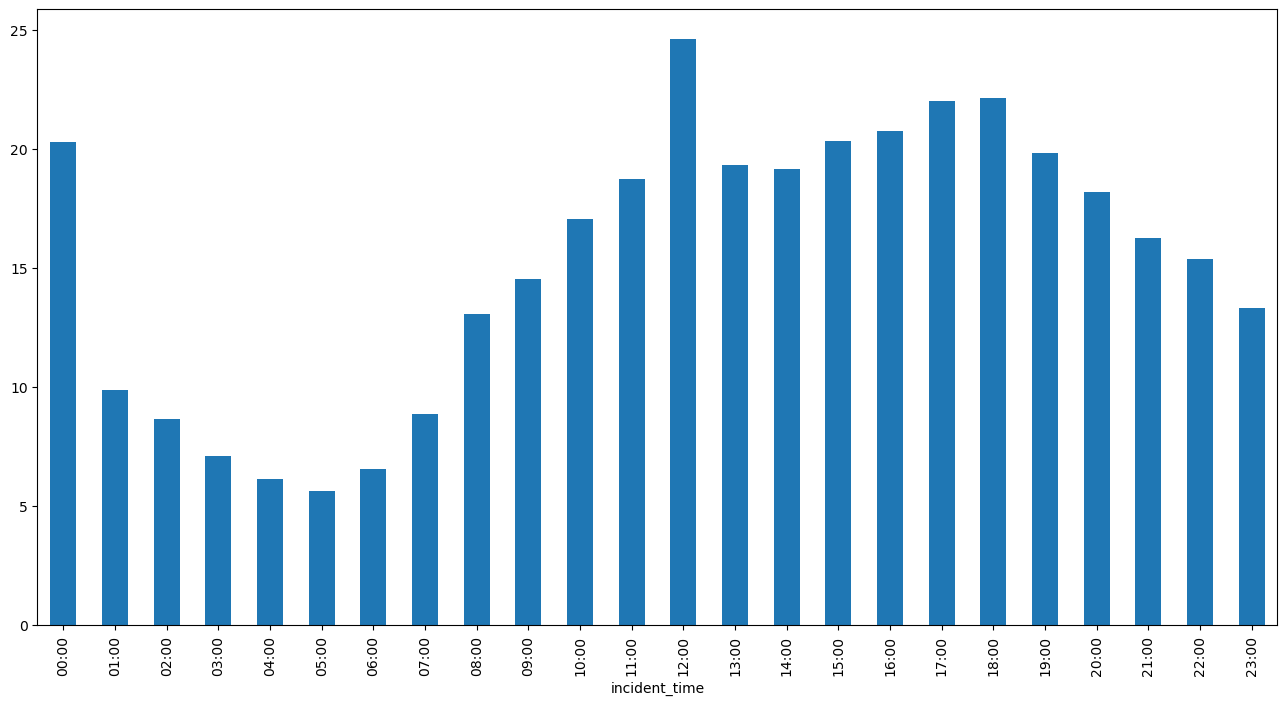

In [45]:
Grouped_SF["crime count"].groupby(Grouped_SF["incident_time"]).mean().plot(figsize=(16,8),kind="bar")

### Hourly Trend Chicago

<Axes: xlabel='incident_time'>

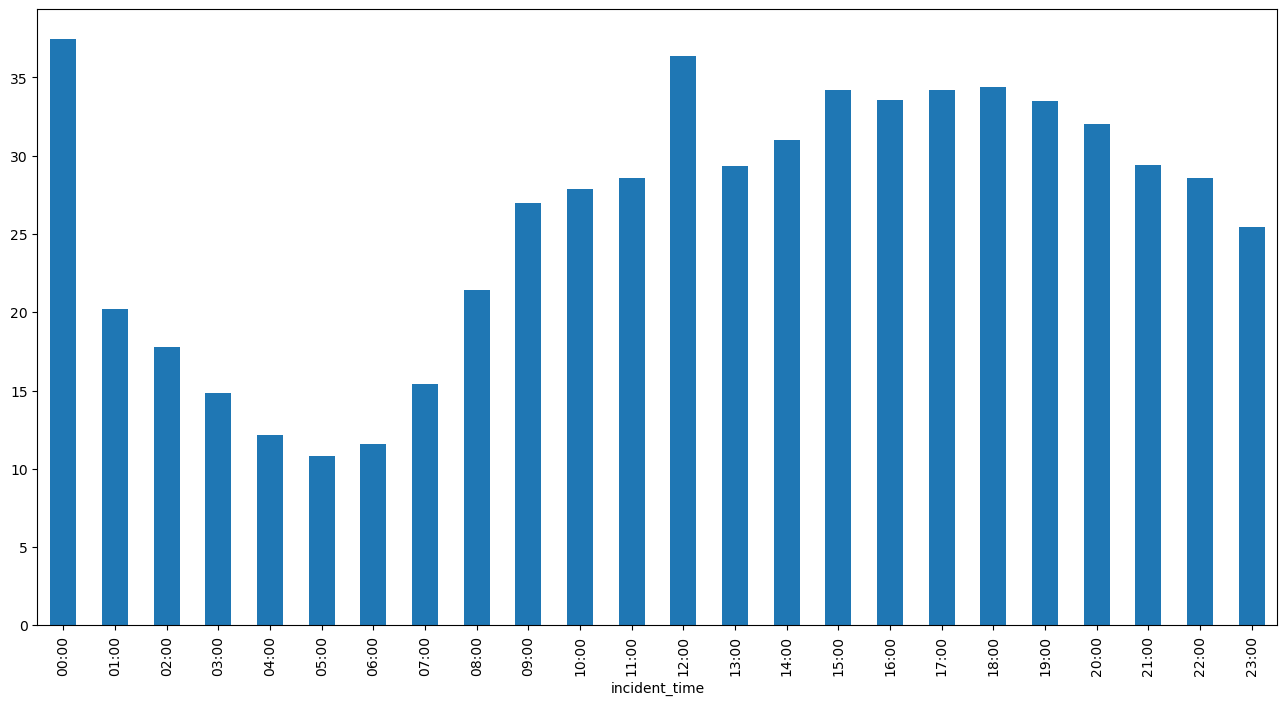

In [127]:
Grouped_Chicago["crime count"].groupby(Grouped_Chicago["incident_time"]).mean().plot(figsize=(16,8),kind="bar")

### Daily Trend SF

<Axes: xlabel='incident_day_of_week'>

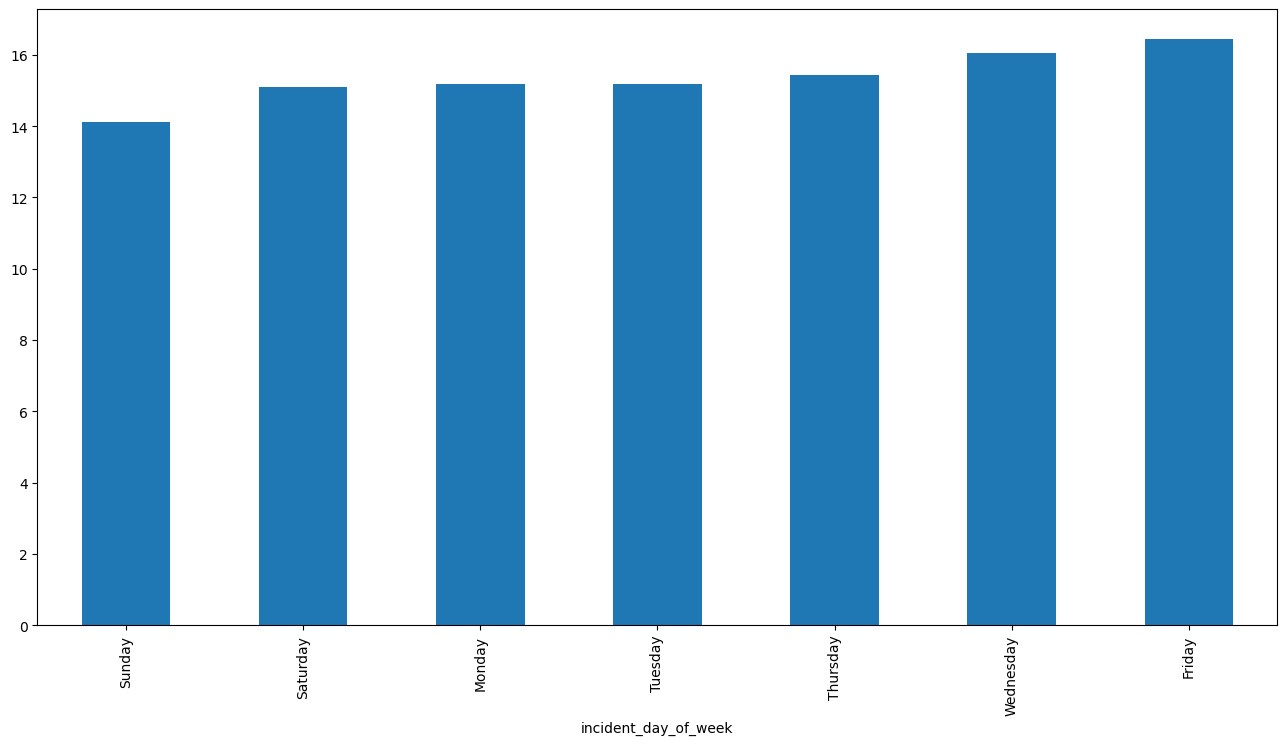

In [129]:
Grouped_SF["crime count"].groupby(Grouped_SF["incident_day_of_week"]).mean().sort_values().plot(figsize=(16,8),kind="bar")

### Daily Trend Chicago

<Axes: xlabel='incident_day_of_week'>

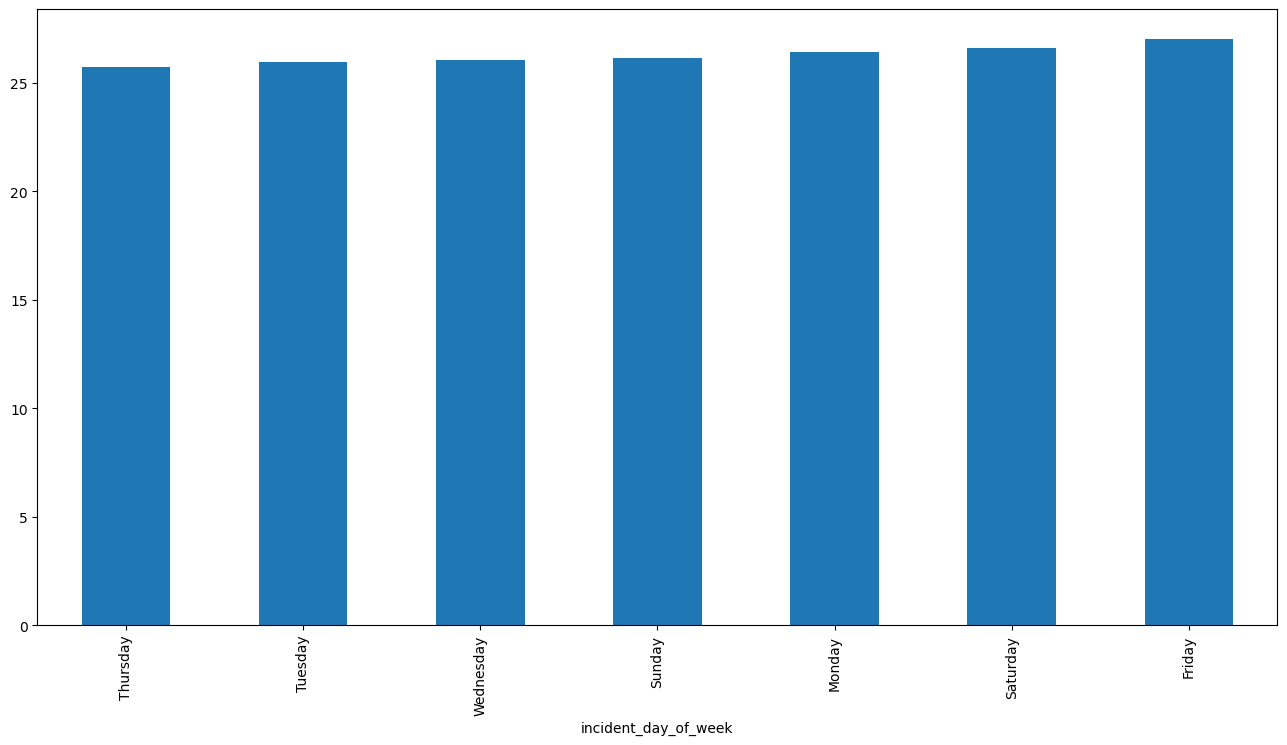

In [128]:
Grouped_Chicago["crime count"].groupby(Grouped_Chicago["incident_day_of_week"]).mean().sort_values().plot(figsize=(16,8),kind="bar")

### Monthly Trend SF

<Axes: xlabel='Month'>

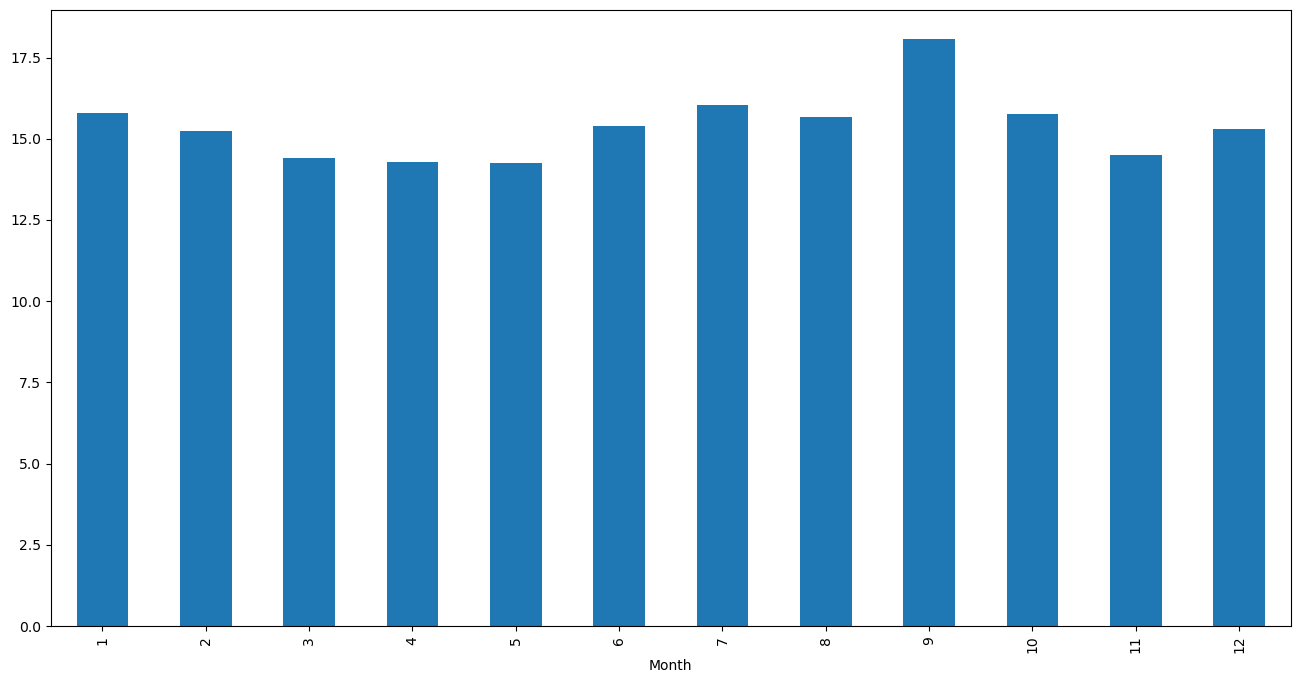

In [52]:
Grouped_SF["crime count"].groupby(Grouped_SF["Month"]).mean().sort_index().plot(figsize=(16,8),kind="bar")

### Monthly Trend Chicago

<Axes: xlabel='Month'>

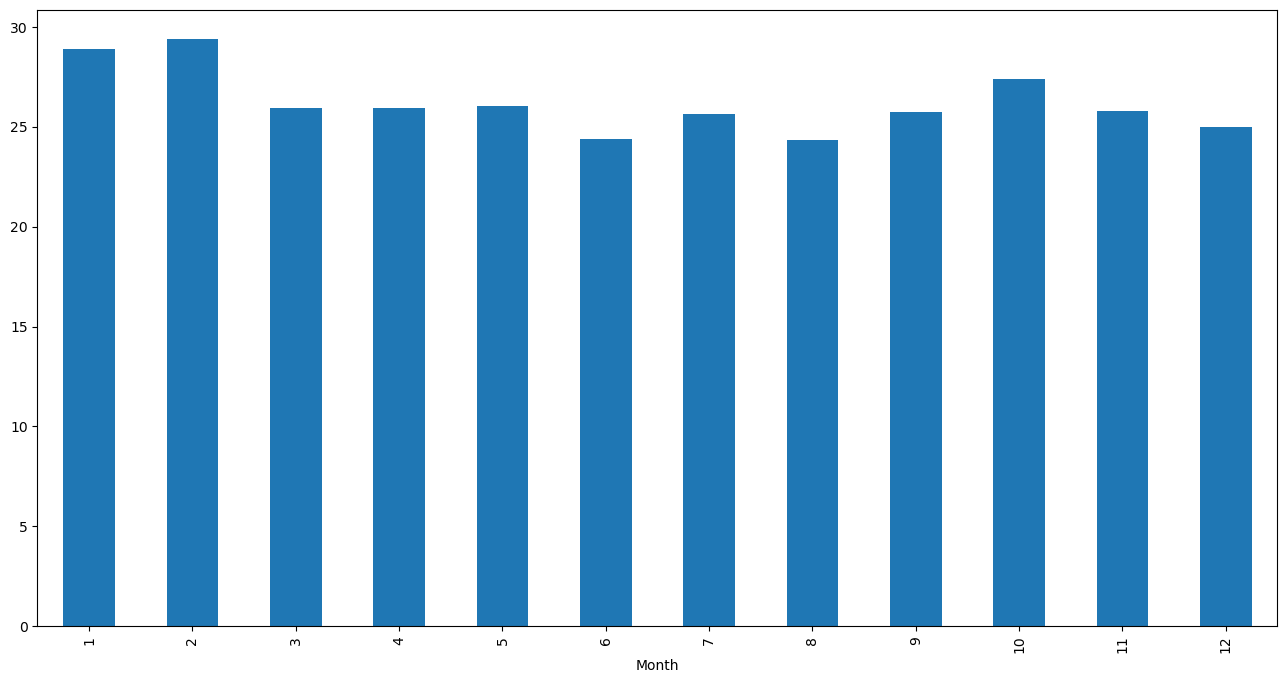

In [130]:
Grouped_Chicago["crime count"].groupby(Grouped_Chicago["Month"]).mean().sort_index().plot(figsize=(16,8),kind="bar")

## Cleaning the Weather Data 


In [53]:
def clean_the_weather(df):

    df['valid'] = pd.to_datetime(df['valid'])

    df['date'] = df['valid'].dt.date
    df['time'] = df['valid'].dt.time

    df["date"]=pd.to_datetime(df["date"])
    df.drop(["valid", "station"], axis=1, inplace=True)
    df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S')



    df['rounded_time'] = df['time'] + pd.to_timedelta(30, unit='T')  
    df['rounded_time'] = df['rounded_time'].dt.strftime('%H:%M')
    df['rounded_time'] = df['rounded_time'].str.split(':').str[0] + ':00'
    df.drop(["time"],axis=1,inplace=True)
    df['date'] = df.apply(lambda row: row['date'] + pd.DateOffset(days=1) if row['rounded_time'] == '00:00' else row['date'], axis=1)
    return df


### Cleaning and Merging the Weather Data (Temperature) for SF

In [54]:
clean_the_weather(SF_TEMP)

KeyError: 'valid'

In [26]:
merged_df_SF=pd.merge(Grouped_SF,SF_TEMP,left_on=["incident_datetime","incident_time"],right_on=["date","rounded_time"])

In [27]:
merged_df_SF

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,crime count,tmpc,date,rounded_time
0,2018-01-01,01:00,2018,Monday,1,29,11.11,2018-01-01,01:00
1,2018-01-01,02:00,2018,Monday,1,23,10.56,2018-01-01,02:00
2,2018-01-01,03:00,2018,Monday,1,15,8.89,2018-01-01,03:00
3,2018-01-01,04:00,2018,Monday,1,8,8.33,2018-01-01,04:00
4,2018-01-01,05:00,2018,Monday,1,10,8.33,2018-01-01,05:00
...,...,...,...,...,...,...,...,...,...
54434,2024-04-07,20:00,2024,Sunday,4,11,12.22,2024-04-07,20:00
54435,2024-04-07,21:00,2024,Sunday,4,8,11.67,2024-04-07,21:00
54436,2024-04-07,22:00,2024,Sunday,4,16,11.67,2024-04-07,22:00
54437,2024-04-07,23:00,2024,Sunday,4,8,11.11,2024-04-07,23:00


### Cleaning and Merging the Weather Data (Temperature) for Chicago

In [131]:
clean_the_weather(Chicago_Temp)

,tmpc,date,rounded_time
0,-18.28,2018-01-01,01:00
1,-18.89,2018-01-01,02:00
2,-19.44,2018-01-01,03:00
3,-20.00,2018-01-01,04:00
4,-20.56,2018-01-01,05:00
...,...,...,...
54872,10.56,2024-04-07,20:00
54873,10.56,2024-04-07,21:00
54874,10.00,2024-04-07,22:00
54875,10.00,2024-04-07,23:00


In [134]:
merged_df_Chicago=pd.merge(Grouped_Chicago,Chicago_Temp,left_on=["date","incident_time"],right_on=["date","rounded_time"])

In [135]:
merged_df_Chicago

,date,incident_time,incident_year,incident_day_of_week,Month,crime count,tmpc,rounded_time
0,2018-01-01,01:00,2018,Monday,1,79,-18.28,01:00
1,2018-01-01,02:00,2018,Monday,1,74,-18.89,02:00
2,2018-01-01,03:00,2018,Monday,1,60,-19.44,03:00
3,2018-01-01,04:00,2018,Monday,1,31,-20.00,04:00
4,2018-01-01,05:00,2018,Monday,1,32,-20.56,05:00
...,...,...,...,...,...,...,...,...
51548,2024-04-07,20:00,2024,Sunday,4,48,10.56,20:00
51549,2024-04-07,21:00,2024,Sunday,4,42,10.56,21:00
51550,2024-04-07,22:00,2024,Sunday,4,44,10.00,22:00
51551,2024-04-07,23:00,2024,Sunday,4,52,10.00,23:00


### Cleaning and Merging the Weather Data (Precipitation) for SF

In [28]:
clean_the_weather(SF_PREC)

,p01m,date,rounded_time
0,0.00,2018-01-01,01:00
1,0.00,2018-01-01,02:00
2,0.00,2018-01-01,03:00
3,0.00,2018-01-01,04:00
4,0.00,2018-01-01,05:00
...,...,...,...
54833,0.00,2024-04-07,20:00
54834,0.00,2024-04-07,21:00
54835,0.00,2024-04-07,22:00
54836,0.00,2024-04-07,23:00


In [29]:
merged_df_SF2=pd.merge(merged_df_SF,SF_PREC,left_on=["incident_datetime","incident_time"],right_on=["date","rounded_time"])

In [30]:
merged_df_SF2

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,crime count,tmpc,date_x,rounded_time_x,p01m,date_y,rounded_time_y
0,2018-01-01,01:00,2018,Monday,1,29,11.11,2018-01-01,01:00,0.00,2018-01-01,01:00
1,2018-01-01,02:00,2018,Monday,1,23,10.56,2018-01-01,02:00,0.00,2018-01-01,02:00
2,2018-01-01,03:00,2018,Monday,1,15,8.89,2018-01-01,03:00,0.00,2018-01-01,03:00
3,2018-01-01,04:00,2018,Monday,1,8,8.33,2018-01-01,04:00,0.00,2018-01-01,04:00
4,2018-01-01,05:00,2018,Monday,1,10,8.33,2018-01-01,05:00,0.00,2018-01-01,05:00
...,...,...,...,...,...,...,...,...,...,...,...,...
54450,2024-04-07,20:00,2024,Sunday,4,11,12.22,2024-04-07,20:00,0.00,2024-04-07,20:00
54451,2024-04-07,21:00,2024,Sunday,4,8,11.67,2024-04-07,21:00,0.00,2024-04-07,21:00
54452,2024-04-07,22:00,2024,Sunday,4,16,11.67,2024-04-07,22:00,0.00,2024-04-07,22:00
54453,2024-04-07,23:00,2024,Sunday,4,8,11.11,2024-04-07,23:00,0.00,2024-04-07,23:00


In [32]:
merged_SF2=merged_df_SF2[["incident_datetime","incident_time","incident_year","incident_day_of_week","Month","tmpc","p01m","crime count"]]
merged_SF2

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count
0,2018-01-01,01:00,2018,Monday,1,11.11,0.00,29
1,2018-01-01,02:00,2018,Monday,1,10.56,0.00,23
2,2018-01-01,03:00,2018,Monday,1,8.89,0.00,15
3,2018-01-01,04:00,2018,Monday,1,8.33,0.00,8
4,2018-01-01,05:00,2018,Monday,1,8.33,0.00,10
...,...,...,...,...,...,...,...,...
54450,2024-04-07,20:00,2024,Sunday,4,12.22,0.00,11
54451,2024-04-07,21:00,2024,Sunday,4,11.67,0.00,8
54452,2024-04-07,22:00,2024,Sunday,4,11.67,0.00,16
54453,2024-04-07,23:00,2024,Sunday,4,11.11,0.00,8


In [33]:
merged_SF2["p01m"]=merged_SF2["p01m"].apply(lambda x: "0" if x=="0.00" else "1").copy()

C:\Users\erent\AppData\Local\Temp\ipykernel_14024\3371413882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_SF2["p01m"]=merged_SF2["p01m"].apply(lambda x: "0" if x=="0.00" else "1").copy()


In [34]:
merged_SF2["p01m"]=merged_SF2["p01m"].astype(int)

C:\Users\erent\AppData\Local\Temp\ipykernel_14024\1976512933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_SF2["p01m"]=merged_SF2["p01m"].astype(int)


In [55]:
merged_SF2

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count
0,2018-01-01,01:00,2018,Monday,1,11.11,0,29
1,2018-01-01,02:00,2018,Monday,1,10.56,0,23
2,2018-01-01,03:00,2018,Monday,1,8.89,0,15
3,2018-01-01,04:00,2018,Monday,1,8.33,0,8
4,2018-01-01,05:00,2018,Monday,1,8.33,0,10
...,...,...,...,...,...,...,...,...
54450,2024-04-07,20:00,2024,Sunday,4,12.22,0,11
54451,2024-04-07,21:00,2024,Sunday,4,11.67,0,8
54452,2024-04-07,22:00,2024,Sunday,4,11.67,0,16
54453,2024-04-07,23:00,2024,Sunday,4,11.11,0,8


### Cleaning and Merging the Weather Data (Precipitation) for Chicago

In [136]:
clean_the_weather(Chicago_Prec)

,p01m,date,rounded_time
0,0.00,2018-01-01,01:00
1,0.00,2018-01-01,02:00
2,0.00,2018-01-01,03:00
3,0.00,2018-01-01,04:00
4,0.00,2018-01-01,05:00
...,...,...,...
54872,0.00,2024-04-07,20:00
54873,0.00,2024-04-07,21:00
54874,0.00,2024-04-07,22:00
54875,0.00,2024-04-07,23:00


In [137]:
merged_df_Chicago2=pd.merge(merged_df_Chicago,Chicago_Prec,left_on=["date","incident_time"],right_on=["date","rounded_time"])

In [138]:
merged_Chicago2=merged_df_Chicago2[["date","incident_time","incident_year","incident_day_of_week","Month","tmpc","p01m","crime count"]]
merged_Chicago2

,date,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count
0,2018-01-01,01:00,2018,Monday,1,-18.28,0.00,79
1,2018-01-01,02:00,2018,Monday,1,-18.89,0.00,74
2,2018-01-01,03:00,2018,Monday,1,-19.44,0.00,60
3,2018-01-01,04:00,2018,Monday,1,-20.00,0.00,31
4,2018-01-01,05:00,2018,Monday,1,-20.56,0.00,32
...,...,...,...,...,...,...,...,...
51560,2024-04-07,20:00,2024,Sunday,4,10.56,0.00,48
51561,2024-04-07,21:00,2024,Sunday,4,10.56,0.00,42
51562,2024-04-07,22:00,2024,Sunday,4,10.00,0.00,44
51563,2024-04-07,23:00,2024,Sunday,4,10.00,0.00,52


In [139]:
merged_Chicago2["p01m"]=merged_Chicago2["p01m"].apply(lambda x: "0" if x=="0.00" else "1").copy()
merged_Chicago2["p01m"]=merged_Chicago2["p01m"].astype(int)

C:\Users\erent\AppData\Local\Temp\ipykernel_14024\3023811575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_Chicago2["p01m"]=merged_Chicago2["p01m"].apply(lambda x: "0" if x=="0.00" else "1").copy()
C:\Users\erent\AppData\Local\Temp\ipykernel_14024\3023811575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_SF2["p01m"]=merged_SF2["p01m"].astype(int)


In [141]:
merged_Chicago2

,date,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count
0,2018-01-01,01:00,2018,Monday,1,-18.28,0,79
1,2018-01-01,02:00,2018,Monday,1,-18.89,0,74
2,2018-01-01,03:00,2018,Monday,1,-19.44,0,60
3,2018-01-01,04:00,2018,Monday,1,-20.00,0,31
4,2018-01-01,05:00,2018,Monday,1,-20.56,0,32
...,...,...,...,...,...,...,...,...
51560,2024-04-07,20:00,2024,Sunday,4,10.56,0,48
51561,2024-04-07,21:00,2024,Sunday,4,10.56,0,42
51562,2024-04-07,22:00,2024,Sunday,4,10.00,0,44
51563,2024-04-07,23:00,2024,Sunday,4,10.00,0,52


### Cleaning the Full Moon Dataset

In [56]:
full_moon_df

,day,month,phase,time,year
0,2,1,Full Moon,02:24,2018
1,31,1,Full Moon,13:27,2018
2,2,3,Full Moon,00:51,2018
3,31,3,Full Moon,12:37,2018
4,30,4,Full Moon,00:58,2018
...,...,...,...,...,...
82,19,8,Full Moon,18:26,2024
83,18,9,Full Moon,02:34,2024
84,17,10,Full Moon,11:26,2024
85,15,11,Full Moon,21:28,2024


In [57]:
full_moon_df['date'] = pd.to_datetime(full_moon_df[['day', 'month', 'year']])
full_moon_df['date'] = full_moon_df['date'].dt.strftime('%Y-%m-%d')
full_moon_df.drop(['day', 'month', 'year'], axis=1, inplace=True)

In [58]:
full_moon_df

,phase,time,date
0,Full Moon,02:24,2018-01-02
1,Full Moon,13:27,2018-01-31
2,Full Moon,00:51,2018-03-02
3,Full Moon,12:37,2018-03-31
4,Full Moon,00:58,2018-04-30
...,...,...,...
82,Full Moon,18:26,2024-08-19
83,Full Moon,02:34,2024-09-18
84,Full Moon,11:26,2024-10-17
85,Full Moon,21:28,2024-11-15


In [59]:
full_moon_df["date"]=pd.to_datetime(full_moon_df["date"])

### Merging the Full Moon Dataset with SF Data, Preproccesing

In [60]:
merged_SF_3=pd.merge(merged_SF2,full_moon_df,left_on=["incident_datetime"],right_on=["date"],how="left")

In [61]:
merged_SF_3['Full Moon'] = merged_SF_3.apply(lambda x: 1 if x['phase'] == 'Full Moon' else 0, axis=1)

In [62]:
merged_SF_3.drop(columns={"phase","time","date"},inplace=True)
merged_SF_3

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count,Full Moon
0,2018-01-01,01:00,2018,Monday,1,11.11,0,29,0
1,2018-01-01,02:00,2018,Monday,1,10.56,0,23,0
2,2018-01-01,03:00,2018,Monday,1,8.89,0,15,0
3,2018-01-01,04:00,2018,Monday,1,8.33,0,8,0
4,2018-01-01,05:00,2018,Monday,1,8.33,0,10,0
...,...,...,...,...,...,...,...,...,...
54450,2024-04-07,20:00,2024,Sunday,4,12.22,0,11,0
54451,2024-04-07,21:00,2024,Sunday,4,11.67,0,8,0
54452,2024-04-07,22:00,2024,Sunday,4,11.67,0,16,0
54453,2024-04-07,23:00,2024,Sunday,4,11.11,0,8,0


In [63]:
merged_SF_3[merged_SF_3["Full Moon"]==1]

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count,Full Moon
23,2018-01-02,00:00,2018,Tuesday,1,11.67,0,15,1
24,2018-01-02,01:00,2018,Tuesday,1,11.67,0,4,1
25,2018-01-02,02:00,2018,Tuesday,1,10.56,0,1,1
26,2018-01-02,03:00,2018,Tuesday,1,10.00,0,6,1
27,2018-01-02,04:00,2018,Tuesday,1,10.00,0,3,1
...,...,...,...,...,...,...,...,...,...
54138,2024-03-25,19:00,2024,Monday,3,12.78,0,12,1
54139,2024-03-25,20:00,2024,Monday,3,12.22,0,21,1
54140,2024-03-25,21:00,2024,Monday,3,12.22,0,14,1
54141,2024-03-25,22:00,2024,Monday,3,12.22,0,9,1


### Merging the Full Moon Dataset with Chicago Data, Preproccesing
## This is where I leave for today

### Does crime count have an association with Full Moon?

In [65]:
merged_SF_3

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count,Full Moon
0,2018-01-01,01:00,2018,Monday,1,11.11,0,29,0
1,2018-01-01,02:00,2018,Monday,1,10.56,0,23,0
2,2018-01-01,03:00,2018,Monday,1,8.89,0,15,0
3,2018-01-01,04:00,2018,Monday,1,8.33,0,8,0
4,2018-01-01,05:00,2018,Monday,1,8.33,0,10,0
...,...,...,...,...,...,...,...,...,...
54450,2024-04-07,20:00,2024,Sunday,4,12.22,0,11,0
54451,2024-04-07,21:00,2024,Sunday,4,11.67,0,8,0
54452,2024-04-07,22:00,2024,Sunday,4,11.67,0,16,0
54453,2024-04-07,23:00,2024,Sunday,4,11.11,0,8,0


To check whether there is an association, I will compare two group means. One of them will be the days with Full Moon and the other will be the days without it. I will perform independent two group t-test to find a p-value. Since I will take the whole day as a "Full Moon" day. I will group my frame by days first.

In [66]:
Full_moondf_SF=merged_SF_3[["incident_datetime","crime count","Full Moon"]].groupby("incident_datetime").agg({"crime count":"sum","Full Moon":"first"}).reset_index()
Full_moondf_SF

,incident_datetime,crime count,Full Moon
0,2018-01-01,434,0
1,2018-01-02,393,1
2,2018-01-03,426,0
3,2018-01-04,468,0
4,2018-01-05,442,0
...,...,...,...
2285,2024-04-04,295,0
2286,2024-04-05,383,0
2287,2024-04-06,263,0
2288,2024-04-07,235,0


In [67]:
Full_moondf_SF.groupby(Full_moondf_SF["Full Moon"]).agg({"crime count":"mean","incident_datetime":"count"}).reset_index()

,Full Moon,crime count,incident_datetime
0,0,367.248192,2212
1,1,374.166667,78


In [68]:


crime_count_full_moon_sf = merged_SF_3[merged_SF_3['Full Moon'] == 1]['crime count']
crime_count_non_full_moon_sf = merged_SF_3[merged_SF_3['Full Moon'] == 0]['crime count']


t_statistic, p_value = ttest_ind(crime_count_full_moon_sf, crime_count_non_full_moon_sf)


print("Two-sample t-test statistic:", t_statistic)
print("P-value:", p_value)

Two-sample t-test statistic: 1.6044840795295876
P-value: 0.10861319024939564


In [69]:


U_statistic, p_value = mannwhitneyu(crime_count_full_moon_sf, crime_count_non_full_moon_sf)

 
print("Mann-Whitney U test statistic:", U_statistic)
print("P-value:", p_value)

Mann-Whitney U test statistic: 49507136.5
P-value: 0.20191012429914734


### Does crime count have an association with Precipitation?

In [70]:
cross_tab_mean_sf = pd.crosstab(index=merged_SF_3['incident_time'], columns=merged_SF_3['p01m'], values=merged_SF_3['crime count'], aggfunc='mean')


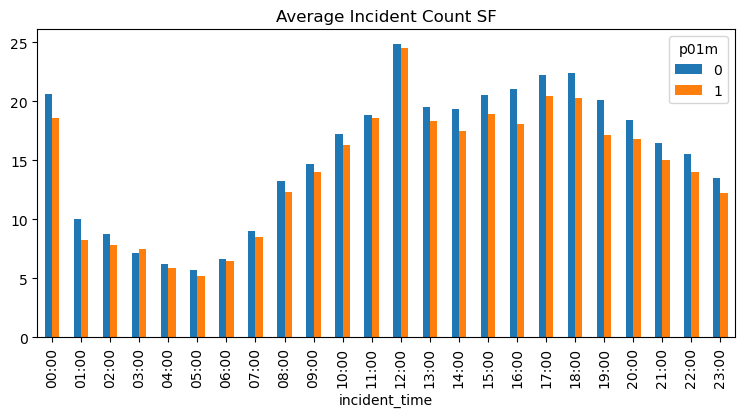

In [71]:
gra=cross_tab_mean_sf.plot(kind='bar', stacked=False,figsize=(9,4))
gra.set_title("Average Incident Count SF")

plt.show()

In [72]:
Stat_SF_prec=merged_SF_3[["incident_time","crime count","p01m"]].copy()

In [73]:
Stat_SF_prec_with_rain=Stat_SF_prec[Stat_SF_prec["p01m"]==1]
Stat_SF_prec_without_rain=Stat_SF_prec[Stat_SF_prec["p01m"]==0]

In [76]:
def compare_hourly_statistics_crime_counts(data_with_rain, data_without_rain):
    hourly_results = {}
    hours = ["{:02d}:00".format(hour) for hour in range(24)]
    
    for hour in hours:
        crime_count_with_rain = data_with_rain[data_with_rain["incident_time"] == hour]["crime count"]
        crime_count_without_rain = data_without_rain[data_without_rain["incident_time"] == hour]["crime count"]
        
        t_statistic, p_value = ttest_ind(crime_count_with_rain, crime_count_without_rain)
        
        hourly_results[hour] = {"t_statistic": t_statistic, "p_value": p_value}
    
    return hourly_results




In [77]:
hourly_comparison_sf_rain = compare_hourly_statistics_crime_counts(Stat_SF_prec_with_rain, Stat_SF_prec_without_rain)

In [78]:
pd.DataFrame(hourly_comparison_sf_rain).T

,t_statistic,p_value
00:00,-2.465192,0.013767
01:00,-4.174625,0.000031
02:00,-2.277430,0.022853
03:00,0.991879,0.321364
04:00,-1.010249,0.312486
05:00,-1.971927,0.048742
06:00,-0.512646,0.608249
07:00,-1.310695,0.190094
08:00,-1.860593,0.062931
09:00,-1.348479,0.177639


### Does crime count have an association with Daily Temperatures?

In [239]:
merged_df3

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count,Full Moon
0,2018-01-01,01:00,2018,Monday,1,11.11,0,29,0
1,2018-01-01,02:00,2018,Monday,1,10.56,0,23,0
2,2018-01-01,03:00,2018,Monday,1,8.89,0,15,0
3,2018-01-01,04:00,2018,Monday,1,8.33,0,8,0
4,2018-01-01,05:00,2018,Monday,1,8.33,0,10,0
...,...,...,...,...,...,...,...,...,...
54728,2024-04-07,20:00,2024,Sunday,4,12.22,0,8,0
54729,2024-04-07,21:00,2024,Sunday,4,11.67,0,3,0
54730,2024-04-07,22:00,2024,Sunday,4,11.67,0,12,0
54731,2024-04-07,23:00,2024,Sunday,4,11.11,0,5,0
